In [432]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import urllib
import tqdm
import datetime

In [433]:
from tensorflow import keras
from keras import datasets, layers
from keras import models, losses
from IPython import display
from keras.utils import Progbar

# Launch tensorboard session
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 2.1 Prepare the Dataset
    This week, we will work with the Quick, Draw! Dataset. The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. 
    We will download the data directly from Google this time. As this process is a little more involved, have a look at this Notebook—here. There, you can find an example of how to download the images into a NumPy array to work with. We will restrict ourselves to sketches of candles only, but feel free to toy around with the other image categories later on. You can also find the notebook as a .ipynb in the homework folder on Courseware. Once you have downloaded the data, you should be able to build your data pipeline from the NumPy array as usual. Consider the following steps:
    • Construct a tf.Data.Dataset object.
    • The images come as (1,784) pixel arrays. You should make sure to reshape them correctly, obtaining small images.
    • Normalize: Bring the images’ values into a sensible range.
    • Perform other beneficial or necessary processing steps

In [434]:
categories = [
    line.rstrip(b'\n') for line in urllib.request.urlopen(
    'https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')
    ]
print(categories[:10])

category = 'candle'

# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). 
# We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]
if not os.path.isdir('../npy_files_homework9'):
    os.mkdir('../npy_files_homework9')

url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'../npy_files_homework9/{category}.npy')

images = np.load(f'../npy_files_homework9/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']
141545 images to train on


In [435]:
# Prepare a dataset
def prepare_dataset(images, batch_size, buffer_size):
    images = images.reshape(train_images.shape[0], 28, 28, 1)
    # Normalize the images to [-1, 1]
    images = (images - 127.5) / 127.5
    dataset = tf.data.Dataset.from_tensor_slices(images)
    # Batch, shuffle and prefetch the data
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


# 2.2 The Model
    Your task is to implement a GAN.
    Create a Discriminator class:
    • __init__(self): The underlying idea of the discriminator is to perform downsampling and then outputting a vector of probabilities indicating whether the input was fake or real.
    • call(self, x, training): This is just a simple call the way you know it, but be aware of the training flag if you decide to use certain optimization and regularization techniques.
    Create a Generator class:
    • init (self): The generator takes a random point from the latent space and returns a generated image. The latent space comes as a 1d vector, so to receive a 2d image you need to reshape it. To increase the size, use upsampling techniques like Conv2DTranspose. In the last layer, perform a convolution with 1 feature map and tanh activation. This will be the output image.
    • call(self, x, training): Same as for the Discriminator.

In [436]:
# Create discriminator class
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layer_1 = tf.keras.layers.Conv2D(
            filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu', 
            padding='same', input_shape=[28, 28, 1])
        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        # layer normalization for trainability
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()

        self.conv_layer_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding='same')
        self.dropout_2 = tf.keras.layers.Dropout(0.3)
        # layer normalization for trainability
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()

        self.flatten = tf.keras.layers.Flatten()
        self.out_layer = tf.keras.layers.Dense(
            units=1, activation='sigmoid'
        )

    def call(self, inputs, training=False):
        x = self.conv_layer_1(inputs)
        if training:
            x = self.dropout_1(x, training=training)
        x = self.batch_norm_1(x)
        x = self.conv_layer_2(x)
        if training:
            x = self.dropout_2(x, training=training)
        x = self.batch_norm_2(x)
        x = self.flatten(x)
        x = self.out_layer(x)

        return x

In [437]:
# Create generator class
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.latent_layer = tf.keras.layers.Dense(
            7*7*256, use_bias=False, input_shape=(100,))
        # layer normalization for trainability
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu_1 = tf.keras.layers.LeakyReLU(alpha=0.3)
        self.reshape = tf.keras.layers.Reshape((7, 7, 256))
        # assert tf.keras.Model.output_shape == (None, 7, 7, 256)

        self.conv_transpose_1 = tf.keras.layers.Conv2DTranspose(
            filters=128, kernel_size=(5, 5), strides=(1, 1),
            use_bias=False, padding='same')
        # assert tf.keras.Model.output_shape == (None, 7, 7, 128)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.leaky_relu_2 = tf.keras.layers.LeakyReLU(alpha=0.3)

        self.conv_transpose_2 = tf.keras.layers.Conv2DTranspose(
            filters=64, kernel_size=(5, 5), strides=(2, 2), 
            use_bias=False, padding='same')
        # assert tf.keras.Model.output_shape == (None, 14, 14, 64)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        self.leaky_relu_3 = tf.keras.layers.LeakyReLU(alpha=0.3)

        self.out_layer = tf.keras.layers.Conv2DTranspose(
            filters=1, kernel_size=(5, 5), strides=(2, 2), activation='tanh',
            use_bias=False, padding='same')
        # assert tf.keras.Model.output_shape == (None, 28, 28, 1)
        
    def call(self, inputs, training=False):
        x = self.latent_layer(inputs)
        x = self.batch_norm_1(x)
        x = self.leaky_relu_1(x)
        x = self.reshape(x)
        x = self.conv_transpose_1(x)
        x = self.batch_norm_2(x)
        x = self.leaky_relu_2(x)
        x = self.conv_transpose_2(x)
        x = self.batch_norm_3(x)
        x = self.leaky_relu_3(x)
        x = self.out_layer(x)

        return x

# 2.3 Training
    There is something novel this week: You will actually need to make some major adjustments to your training step() function and the overall training procedure. 
    In each training step, the generator is fed with random noise9 and creates images from it. 
    The discriminator sees a batch of true images and a batch of the generated images. The loss of the discriminator is based on how well the discriminator detected fake images as fake and real images as real10

    The loss of the generator is estimated by how well the generator was able to fool the discriminator. The more images the discriminator falsely classified as real, the better our generator works and the smaller the Binary Cross Entropy loss between the discriminator’s predictions and all labels as true=1.
    Training Hyperparameters for orientation can be found in this footnote.
    • epochs: 10 is a good starting point, then see if you want to train longer or if you are already satisfied with the quality of the generated images
    • optimizer: Adam or RMSprop
    
    We recommend visualizing the losses and output images using TensorBoard. Be aware that, unlike in your previous architectures, the goal is not to get the loss as low as possible. The loss of the generator or discriminator going against zero is actually a sign of training failure.
    For evaluation, you should therefore create some random latent vectors before training and feed them through the generator regularly. You can plot the resulting images to evaluate training.
    Training GANs is messy, and it is sometimes hard to pinpoint the reason why training fails. But as our input images are not of the greatest quality anyway, your GAN should in the end be very capable of approximating these sketches.

In [438]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [439]:
# Quantifies how well the discriminator is able to distinguish real images from fakes. 
# It compares the discriminator's predictions on real images to an array of 1s, and the 
# discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [440]:
# The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, 
# if the generator is performing well, the discriminator will classify the fake images as real (or 1). 
# Here, compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [441]:
def saves_checkpoints(generator, discriminator, generator_optimizer, discriminator_optimizer):
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                        discriminator_optimizer=discriminator_optimizer,
                                        generator=generator,
                                        discriminator=discriminator)

    return checkpoint_prefix, checkpoint

In [442]:
# `tf.function` annotation causes the function to be "compiled".
@tf.function
def train_step(images, discriminator, generator, batch_size, 
                noise_dim, generator_optimizer, discriminator_optimizer):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [443]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig(f'./saved_images/image_at_epoch_{epoch:04d}.png')
    plt.show()

In [444]:
def train(generator, discriminator, train_ds, epochs, 
            batch_size, noise_dim, generator_optimizer, 
            discriminator_optimizer, checkpoint, 
            checkpoint_prefix, seed):

    for epoch in range(epochs):
        start = time.time()
        print(f'Epoch: {epoch + 1}/{epochs}')

        for image_batch in tqdm.tqdm(train_ds, position=0, leave=True):
            train_step(image_batch, discriminator, generator, batch_size,
                        noise_dim, generator_optimizer, discriminator_optimizer)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            generate_and_save_images(generator, epoch, seed)
        
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    # Generate after the final epoch 
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [445]:
# Display a single image using the epoch number
def display_image(epoch_number):
    return PIL.Image.open(f'./saved_images/image_at_epoch_{epoch_number:04d}.png')

In [446]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
train_dataset = prepare_dataset(train_images, BATCH_SIZE, BUFFER_SIZE)

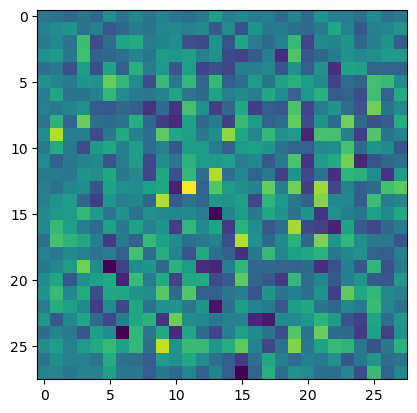

In [447]:
generator = Generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

In [448]:
discriminator = Discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49968377]], shape=(1, 1), dtype=float32)


In [449]:
# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [450]:
epochs = 25
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

checkpoint_prefix, checkpoint = saves_checkpoints(generator, 
                                                        discriminator,
                                                        generator_optimizer, 
                                                        discriminator_optimizer)

Epoch: 1/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.85it/s]


Time for epoch 1 is 21.67246961593628 sec
Epoch: 2/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]


Time for epoch 2 is 23.955425024032593 sec
Epoch: 3/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:45<00:00,  1.14s/it]


Time for epoch 3 is 45.56371474266052 sec
Epoch: 4/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.19s/it]


Time for epoch 4 is 47.730472564697266 sec
Epoch: 5/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.19s/it]


Time for epoch 5 is 47.72547245025635 sec
Epoch: 6/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.19s/it]


Time for epoch 6 is 47.765809059143066 sec
Epoch: 7/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.19s/it]


Time for epoch 7 is 47.702898263931274 sec
Epoch: 8/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.19s/it]


Time for epoch 8 is 47.73391604423523 sec
Epoch: 9/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.19s/it]


Time for epoch 9 is 47.73392367362976 sec
Epoch: 10/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.19s/it]


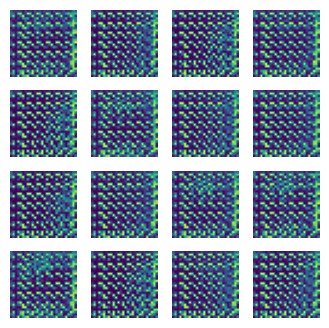

Time for epoch 10 is 50.53963041305542 sec
Epoch: 11/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:46<00:00,  1.17s/it]


Time for epoch 11 is 46.91515922546387 sec
Epoch: 12/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:48<00:00,  1.21s/it]


Time for epoch 12 is 48.59114360809326 sec
Epoch: 13/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:48<00:00,  1.22s/it]


Time for epoch 13 is 48.7216420173645 sec
Epoch: 14/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.23s/it]


Time for epoch 14 is 49.19998502731323 sec
Epoch: 15/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.24s/it]


Time for epoch 15 is 49.561447620391846 sec
Epoch: 16/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.24s/it]


Time for epoch 16 is 49.66175627708435 sec
Epoch: 17/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.25s/it]


Time for epoch 17 is 50.0514817237854 sec
Epoch: 18/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.26s/it]


Time for epoch 18 is 50.34830951690674 sec
Epoch: 19/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.26s/it]


Time for epoch 19 is 50.508586168289185 sec
Epoch: 20/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.28s/it]


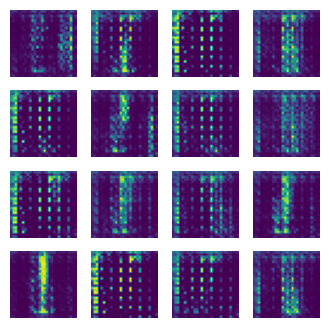

Time for epoch 20 is 54.842055559158325 sec
Epoch: 21/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.24s/it]


Time for epoch 21 is 49.72102165222168 sec
Epoch: 22/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it]


Time for epoch 22 is 51.45170855522156 sec
Epoch: 23/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.30s/it]


Time for epoch 23 is 52.07191610336304 sec
Epoch: 24/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.31s/it]


Time for epoch 24 is 52.61374235153198 sec
Epoch: 25/25


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.30s/it]


Time for epoch 25 is 52.037633419036865 sec


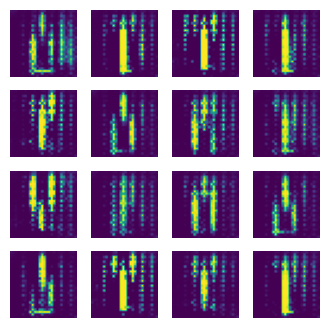

In [451]:
train(generator=generator,
        discriminator=discriminator,
        train_ds=train_dataset,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        noise_dim=noise_dim,
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer,
        checkpoint=checkpoint,
        checkpoint_prefix=checkpoint_prefix,
        seed=seed)

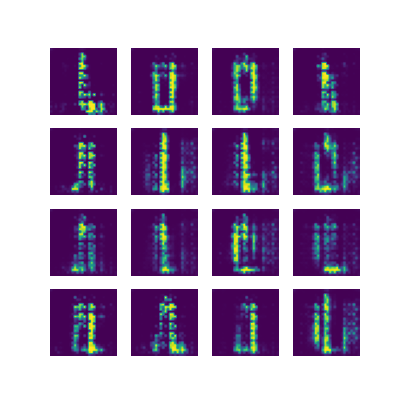

In [388]:
display_image(epochs)

In [452]:
%tensorboard --logdir 'training_checkpoints/checkpoint'

Reusing TensorBoard on port 6006 (pid 15924), started 22:12:15 ago. (Use '!kill 15924' to kill it.)